# Quantitative Trading Strategy # 4

## FX Carry Strategy

## Sections
1. Objectives
2. Preliminaries
3. Data Imports
4. Carry Trade Strategy
5. Correlations of the Carry Trading Returnss
6. Conclusions

## 1. Objectives

An FX carry strategy borrows in a (low-interest-rate, generally developed market) currency and lends in another currency (with high interest rates, generally Emerging market). The motivation is to generate the returns from the spread between these two interest rates. The major risk to this strategy is the FX Rate risk. Theoretically, by Covered Interest Rate and Inflation pairity dynamics, emerging market currencies should depreciate with respect to developed market currencies and thus neutralize such profit opportunities. However, empirical data suggests that such carry trades have been profitable, in general, over long periods of time. 

This is a simulation of FX Carry Trade strategy implemented by a US based investor who borrow for short term (one week) in British Pound Sterling (GBP) using Overnight Index Swap Rates. The investor then lends this borrowed amount (and some own capital) in to emerging market debt. To further enhance the returns, the investor chooses long term debt (5 years) which is then sold at the end of one week to return the borrowed GBP sum.

The period of study had some major economic events including <b> the Brexit referendum in June 2016 after which the British Pound weakened substantially. </b> In 2020, at the onset of the Covid-19 crisis, most countries lowered the interest rates substantially to have a accomodating monetry policy. It would be interesting to analyze the performance of the strategies in this backdrop.

The strategy is evaluated in two respects:

<b> 1. Stand alone strategy backtesting:</b> We would see the performance of our strategy by analyzing the interest rate differentials and currency rate trends for four different Emerging Market (a) South Africa, (b) Thailand, (c) Philippines, and (d) Pakistan. Then, we shall backtest the return performance of the FX Carry Trading Strategy that rebalnces its borrowing and lending positions every week.

<b> 2. Portfolio level analysis - Correlations:</b> Currency Carry Trade strategies could be highly correlated with carry trades in other currencies as Emerging Market debt and currencies are considered to be highly correlated. We thus analyze the overall and across time correlations of these strategies to better understand how these strategies could be incorporated in our portfolios.   

<b> Assumptions </b>:
- We can borrow for one week in GBP at the existing OIS rate + 50 bps with interest computed on A/360 basis every week
- We can take 1 week positions at the Zero coupon yield in each of the emerging market debt instrument considered
- We can convert among the currencies at the existing market rate

## 2. Preliminaries

Here, we define the various Python libraries used here, most of the functions that shall be used later in the assignment and some Global Variables (names capitalized) used in this analysis. 

#### Global Variables (Upper Case convention) used in the analysis

In [1]:
#Global Variables
START_DT = '2009-01-01'
END_DT = '2021-12-08'

#Country specific variables
GB = {'Country':'United Kingdom','Currency':'British Pound Sterling','Yield':'UK Yield'}
SA = {'Country':'South Africa','Currency':'South African Rand','Yield':'South African Yield'}
TH = {'Country':'Thailand','Currency':'Thai Baht','Yield':'Thai Yield'}
PAK = {'Country':'Pakistan','Currency':'Pakistani Rupee','Yield':'Pakistani Yield'}
PHL = {'Country':'Philippines','Currency':'Philippine Peso','Yield':'Philippine Yield'}

#### Python librarires

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nasdaqdatalink
import seaborn as sns
#import statsmodels.api as sm
import scipy.stats as stats
sns.color_palette("mako", as_cmap=True)
plt.rcParams["figure.figsize"] = [15,6]

import warnings
warnings.filterwarnings('ignore')

#### Key functions used in the analysis

In [3]:
def summaryStats(df):    
    '''
    function to display the summary statistics of a given dataframe
    '''    
    summary = pd.DataFrame(index = df.columns)    
    summary['Mean Annualized Return (NonCompunded)'] = df.mean()*52
    summary['Annualized Volatility'] = df.std()*np.sqrt(52)
    summary['Sharpe Ratio'] = summary['Mean Annualized Return (NonCompunded)']/summary['Annualized Volatility']    
    summary['Skewness'] = df.skew()
    summary['Excess Kurtosis'] = df.kurt()
    summary['Biggest Loss'] = df.min()
    summary['Maximum Gain'] = df.max() 
    summary['% time positive'] = round(100*(df > 0).sum()[0]/len(df),2)
        
    return summary

In [4]:
def compute_zcb_curve(spot_rates_curve, tenors):
    
    '''
    Function to compute Zero Coupon Curve from a given Spot Rate Curve 
    Tenors: list of maturity dates to be considered while building the Zero Coupon Curve
    '''    
    zcb_rates = spot_rates_curve.copy()    
    zcb_rates = zcb_rates.iloc[:,:len(tenors)].fillna(method ='ffill')
    zcb_rates.columns = tenors
    zcb_rates = zcb_rates.T    
    
    for curve in zcb_rates.columns:
        spot = zcb_rates[curve]
        for tenor, spot_rate in spot.iteritems():
            if tenor>0.001:
                times = np.arange(tenor-0.5, 0, step=-0.5)[::-1]
                coupon_half_yr = 0.5*spot_rate
                z = np.interp(times, zcb_rates[curve].index.values, zcb_rates[curve].values) # Linear interpolation
                preceding_coupons_val = (coupon_half_yr*np.exp(-z*times)).sum()
                zcb_rates[curve][tenor] = -np.log((1-preceding_coupons_val)/(1+coupon_half_yr))/tenor    
    
    zcb_rates = zcb_rates.T
    df = pd.DataFrame(index = pd.date_range(START_DT,zcb_rates.last_valid_index()),columns=zcb_rates.columns)
    
    for col in df:
        df[col] = zcb_rates[col]
        df[col] = df[col].fillna(method='ffill')
    
    df = df.dropna()
    df = df.resample('W-WED').ffill()
    return df

In [5]:
def buildStrategy(country,debtRatio = 0.8,FCYlendingTenor = 5.00, FCYexitTenor = 4+51/52,GBPfundingSpread = 0.005):
    '''
    Given a country (global variable), builds a Carry Trade strategy by borrowing in GBP and lending in the country
    The strategy invests in long tenor bond (default 5 years) of the country for 1 week and exits the position at the 
    end of each week
    '''  
    zcb = country['zcb']
    FCYexchange = country['exchange']
        
    tradeDates = zcb.index
    strategy = strategyBuilder.copy()
    
    for i,(ent,ext) in enumerate(zip(tradeDates,tradeDates[1:])):
        # No Trades if less than 50 bps spread between FCY lending and GBP 5 year zero coupon rate
        if GB['zcb'].loc[ent][FCYlendingTenor] + 0.005 > zcb.loc[ent][FCYlendingTenor]:            
            strategy.loc[i] = [ent,ext]+[0 for _ in range(len(strategy.columns)-2)]
            continue        

        USDNtl = 10e6
        USDcash = (1-debtRatio) * USDNtl

        usd_gbp_enter = GB['exchange'].loc[ent]['RATE']
        eqvGBP = USDNtl * usd_gbp_enter    
        borrowGBP = debtRatio*eqvGBP
        gbpOIS = GB['OIS'].loc[ent]    
        fundingGBP = gbpOIS + GBPfundingSpread  
        interestGBP = (ext-ent).days/360 * fundingGBP * borrowGBP

        usd_gbp_exit = GB['exchange'].loc[ext]['RATE']    
        amountUSD = (interestGBP+borrowGBP)/usd_gbp_exit

        fcy_usd_enter = FCYexchange.loc[ent]['RATE']
        lendFCY = USDNtl*fcy_usd_enter
        enterZCRate = zcb.loc[ent][FCYlendingTenor]
        bondPriceEnt = np.exp(-enterZCRate*FCYlendingTenor)

        exitZCRate = np.interp(FCYexitTenor,zcb.columns,zcb.loc[ext])
        bondPriceExt = np.exp(-exitZCRate*FCYexitTenor)
        realizedFCY = lendFCY * bondPriceExt/bondPriceEnt

        fcy_usd_exit =  FCYexchange.loc[ext]['RATE']
        realizedUSD = realizedFCY/fcy_usd_exit

        pnl = realizedUSD - amountUSD - USDcash

        strategy.loc[i] = [ent,ext,USDNtl,\
                           usd_gbp_enter,eqvGBP,borrowGBP,gbpOIS,fundingGBP,interestGBP,\
                           usd_gbp_exit,amountUSD,\
                           fcy_usd_enter,lendFCY,enterZCRate,bondPriceEnt,\
                           exitZCRate,bondPriceExt,realizedFCY,\
                           fcy_usd_exit,realizedUSD,\
                           pnl,0]
    
    strategy['CumPnLUSD'] = strategy['PnL'].cumsum()
    strategy['returns'] = strategy['PnL']/USDcash
    
    return strategy

In [6]:
def carry_trade_potential(country,FCYlendingTenor = 5.00,GBPfundingSpread = 0.005):
    '''
    Function to plot and show the backtested performance of the carry trade strategy
    '''        
    zcb,FCYexchange = country['zcb'],country['exchange']
    fig, (ax,ax2) = plt.subplots(2,1, figsize=(15, 10))
    
    yld =country['Yield']
    color = 'tab:red'    
    ax.set_ylabel('Carry Interest/FX Rate Change', fontsize = 14)
    ax.plot(zcb[FCYlendingTenor] - GB['OIS'].loc[zcb[FCYlendingTenor].index] - GBPfundingSpread, \
             color=color, label = f'Carry Interest: {FCYlendingTenor}yr {yld} - GBP Funding')
    
        
    GBP_FCY = FCYexchange.loc[zcb[FCYlendingTenor].index]/GB['exchange'].loc[zcb[FCYlendingTenor].index]
    GBP_FCY['change'] = (GBP_FCY['RATE']/GBP_FCY['RATE'].shift() - 1).dropna()    
    color = 'tab:blue'
    ax.plot(GBP_FCY['change'], color=color,label = 'Change in GBP/'+country['Currency']+' exchange rate')  
        
    avgChange = round(100*GBP_FCY['change'].mean(),4)
    ax.axhline(y=GBP_FCY['change'].mean(),c = 'm',\
               label = f'Mean weekly change in FX Rate = {avgChange}%, (Approx {round(52*avgChange,2)}% per year)')
       
    ax.set_title('Potential: Carry Trade spreads', fontsize = 14)
    ax.legend()   
    
    profit = country['Strategy'].CumPnLUSD.iloc[-1]
    capital = 2e6
    years = (country['Strategy'].ExitDate.iloc[-1] - country['Strategy'].EnterDate.iloc[0]).days/365.25
    roc = round((profit/capital/years) *100,0)
        
    ax2.set_ylabel('USD Million',fontsize = 14) 
    ax2.plot(country['Strategy']['EnterDate'],country['Strategy']['CumPnLUSD'],label = 'Cummulative P&L',color = 'c')
     
    yr_start = country['Strategy'].set_index('ExitDate').iloc[0].name.year
    yr_end = country['Strategy'].set_index('ExitDate').iloc[-1].name.year
    color = lambda x: 'g' if x > 0 else 'r'
    label = lambda x: 'Total Profit for year' if x > 0 else 'Total Loss for year'

    for y in range(yr_start,yr_end+1):
        yearly = country['Strategy'].set_index('ExitDate').loc[str(y)]
        profit = yearly.PnL.sum()
        ax2.plot(yearly.index,[profit for _ in range(len(yearly))],color = color(profit),label = label(profit))
        
    #remove duplicate labels from the plot legend
    handles, labels = plt.gca().get_legend_handles_labels()    
    newLabels, newHandles = [], []
    for handle, label in zip(handles, labels):
        if label not in newLabels:
            newLabels.append(label)
            newHandles.append(handle)
    plt.legend(newHandles, newLabels)       
    
    ax2.set_xlabel('Year',fontsize = 14)
    ax2.set_title(f'Backtested: Year-wise and Cummulative Profit and Loss \n Leveraged Annualized ROC = {roc}%',\
                  fontsize = 14)      
    plt.suptitle(country['Country']+'-UK Carry Trade: Potential and Backtested Profitability', fontsize = 18)
    fig.tight_layout() 
    plt.show()
    
    display(summaryStats((country['Strategy']['PnL']/2e6).to_frame(country['Country']+'-UK Weekly Carry Trade Returns')))

In [7]:
def distribution_analysis(country):
    '''
    Function to plot the distribution of weekly return series to evaluate Kernal Density and study the outlier behavior
    '''    
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15, 8))

    returns = country['Strategy']['PnL']/2e6
    norm_returns = (returns - returns.mean())/returns.std()

    ax = sns.distplot(norm_returns,bins = 40,ax = ax1)
    ax.set_xlabel('Normalized Weekly Return',fontsize = 12)
    ax.set_ylabel('Density',fontsize = 12)
    ax.set_title('Kernal Density of Weekly Returns',fontsize = 14)

    stats.probplot(norm_returns, dist="norm", plot=ax2)
    ax2.set_title('Quantile-Quantile Plot of Weekly Returns',fontsize = 14)
    ax2.set_xlabel('Theoretical Quantiles',fontsize = 12)
    ax2.set_ylabel('Observed Quantiles',fontsize = 12)
    
    plt.suptitle(country['Country']+'-UK Carry Trade: Distribution of Weekly Returns', fontsize = 18)
    plt.show()

## 3. Data Imports
From the Nasdaqdatalink (Quandl), we use the YC dataset to get the Yield Curves for various currencies (includind OIS rates for Great Britain). Also we use the CUR data set to get the FX currency rates with respect to US Dollar

In [8]:
nasdaqdatalink.ApiConfig.api_key = 'YourAPIkey'
getYieldCurve = lambda CountryCode: nasdaqdatalink.get('YC/'+CountryCode,start_date=START_DT, end_date=END_DT)/100
getCurrencyRate = lambda CountryCode: nasdaqdatalink.get('CUR/'+CountryCode,start_date=START_DT, end_date=END_DT)

#### Fetch Currency Data and Resample to have data for each Wednesday only

In [9]:
GB['exchange'] = getCurrencyRate('GBP').resample('W-WED').ffill()
SA['exchange'] = getCurrencyRate('ZAR').resample('W-WED').ffill()
TH['exchange'] = getCurrencyRate('THB').resample('W-WED').ffill()
PAK['exchange'] = getCurrencyRate('PKR').resample('W-WED').ffill()
PHL['exchange'] = getCurrencyRate('PHP').resample('W-WED').ffill()

#### Fetch Great Britain OIS and the yield curves for each country

In [10]:
GB['OIS'] = getYieldCurve('GBR_ISSC')['0.08Y'].resample('W-WED').ffill()
GBR_yield = getYieldCurve('GBR').fillna(method ='ffill')

SA_yield = getYieldCurve('ZAF').fillna(method ='ffill')
SA_yield['5-Year'] = (SA_yield['12-Month']+SA_yield['5to10-Year'])/2
SA_yield = SA_yield.drop(columns=['3-Month','6-Month','9-Month','3to5-Year','5to10-Year','10-Year']).dropna()


TH_yield = getYieldCurve('THA').fillna(method ='ffill')
TH_yield = TH_yield.drop(columns=['1-Month','3-Month','6-Month'])

PAK_yield = getYieldCurve('PAK').fillna(method ='ffill')
PAK_yield = PAK_yield.drop(columns = ['3-Month','6-Month'])

PHL_yield = getYieldCurve('PHL').fillna(method ='ffill')
PHL_yield = PHL_yield.drop(columns = ['1-Month','3-Month','6-Month'])

Once we have the yield curve for each of the country considered, we build the Zero Coupon Rates from the available yield curves. <b> Note that we have dropped the money market yield rates of less than 1 year as we may not have full information of the associated cash flows of these rates. </b> For South Africa, we are assuming 5 year yields to be at the mean of 1 year and 10 year yields.

#### Build Zero Coupon Rates from Spot Rates

In [11]:
SA['zcb'] = compute_zcb_curve(SA_yield,[1,5])
TH['zcb'] = compute_zcb_curve(TH_yield,[1,2,3,4,5])
PAK['zcb'] = compute_zcb_curve(PAK_yield,[1,3,5])
PHL['zcb'] = compute_zcb_curve(PHL_yield,[1,2,3,4,5])

GB['zcb'] = compute_zcb_curve(GBR_yield,[5])

## 4. Carry Trade Strategy

For each of the four emerging market countries, we now study the potential from undertaking a Carry Trade strategy. We then analyze the return and risk distributions to understand how practical the strategy is for our use.

In [12]:
strategyBuilder = pd.DataFrame(columns = ['EnterDate','ExitDate','USDNotional',\
                                   'USD-GBP_Ent','EqvGBP','BorrowGBP','GBP_OIS','GBPFundingRate','InterstGBP',\
                                   'USD-GBP_ext','ReturnAmountUSD',\
                                   'FCY_USD_Ent','LendFCY','EnterZCRate','5YBondP',\
                                   'ExitZCRate','BondPriceExt','RealizedFCY',
                                   'FCY_USD_ext','RealizedUSD','PnL','CumPnLUSD'])
strategyBuilder.index.name = 'Week'

In [13]:
PAK['Strategy'] = buildStrategy(PAK)
PHL['Strategy'] = buildStrategy(PHL)
SA['Strategy'] = buildStrategy(SA)
TH['Strategy'] = buildStrategy(TH)

### I. South Africa

Until 2019, South African central banks had been keeping loose monetry policy and keeping the interest rates stable. In 2020, the central bank raised rates temporarily but had to start cutting again at the onset of Covid 19 crisis. 

With a carry interest rate differential of close to 6%, South Africa is an interesting destination for carry trade.

#### Carry Trade potential

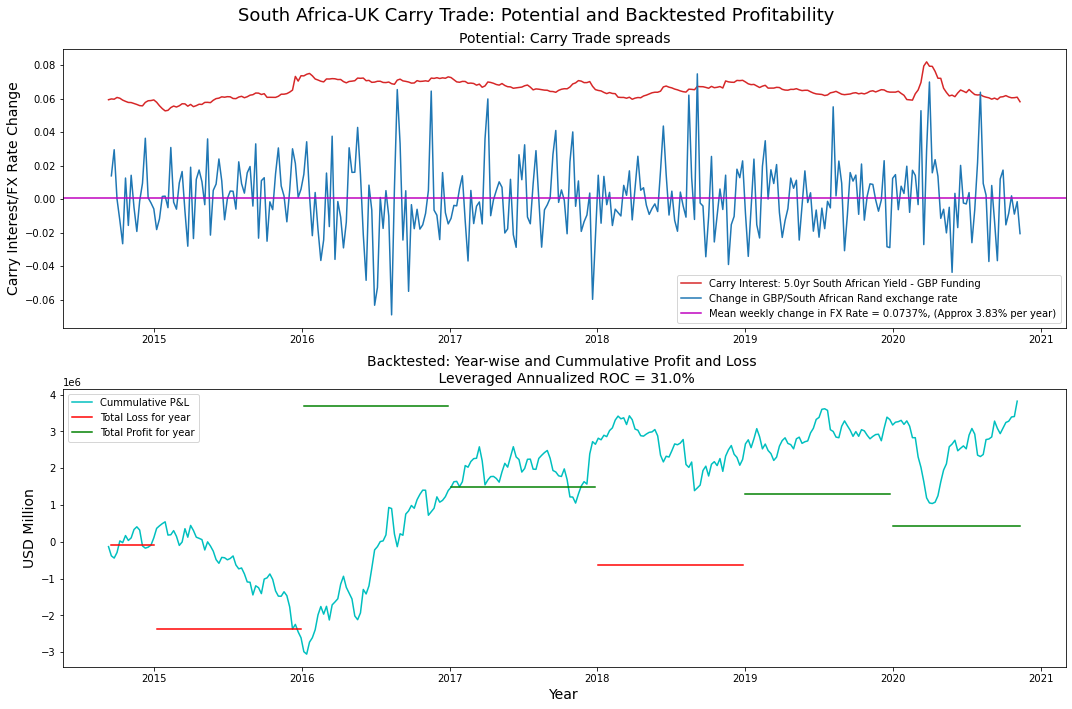

,Mean Annualized Return (NonCompunded),Annualized Volatility,Sharpe Ratio,Skewness,Excess Kurtosis,Biggest Loss,Maximum Gain,% time positive
South Africa-UK Weekly Carry Trade Returns,0.308604,0.856242,0.360416,-0.233121,0.98434,-0.388843,0.409148,54.97


In [14]:
carry_trade_potential(SA)

#### Observations: <br>
<b>1. Interest Differentials: </b>We observe a healthy and steady carry interest differential of about 6% to 8% between 5 year South African Zero Coupon rate and the British Lending rate of OIS + 50 bps.  
<b>2. Exchange Rates :</b> The GBP/ZAR (South African Rand) exchange rate plotted here was more volatile with weekly changes often going in the 4% to 6% ranges. However, almost at each instance we observe mean reversions. The overall depreciation of South African Rand averages at around 3.83% , much less than the carry interest in the fixed income securities. <br>
<b> 3. Yearly Performances : </b> The strategy loses money up to 2016. We can observe narrowly rising interest spreads during this period coupled with much steeper ZAR depreciations, to which we may attribute these losses.This was reversed from 2016 to 2018 with some declines in carry rates after first quarter of 2016.<br>
In 2020, we see a steep decline in profitability at the onset of the Covid-19 crisis. At the same time we had a large increase in carry interest. Note that our weekly carry trade strategies would lose money from spread increases as we would be required to exit positions at higher spreads. The ZAR also depricated remarkably at this time. However, the trend was reveresed soon and the losses were covered.<br>
<b> 4. Strategy Returns : </b> The strategy gives a healthy annualized Return on Capital of 31% with leverage. (<u> Note that mean annualized return of 0.30 in the table is based on approximate weekly multiplication factor of 52 and thus only closely matches the actual reported ROC </u>). However the returns are fairly volatile from week to week and from year to year. <b> This may be expected in Fixed Income carry trade strategies which have reverting FX fluctuations.</b> The strategy provided positive returns for about 55% of the time periodsthat was adequate in generating fair returns. 
    
As opposed to general expectation of negative skew in carry trade, this strategy does not exhibit very high skewness and kurtosis in returns. We study the distributions of returns next.

#### Distribution of Returns
Now we track the distribution of our return series to better categorize the probability and magnitude of our expected losses.

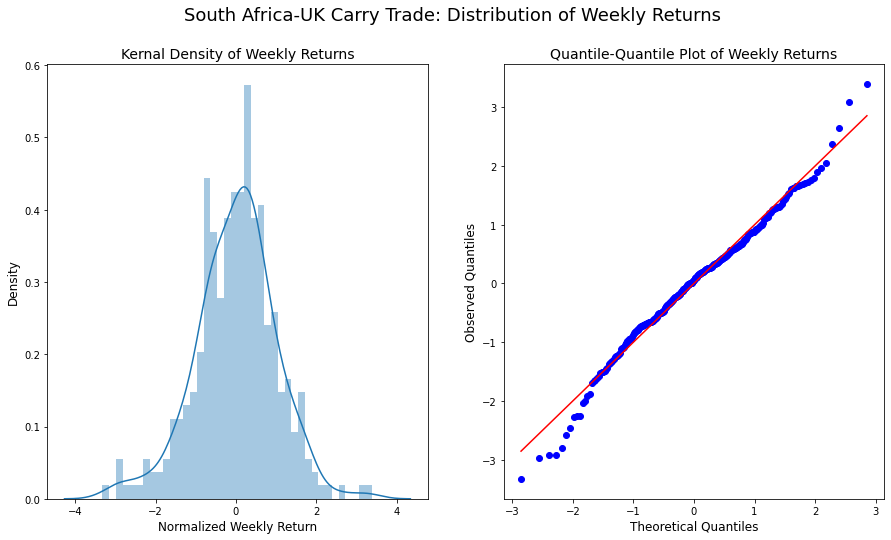

In [15]:
distribution_analysis(SA)

<b> Observations: </b> 

<b> 1. Kernal Density: </b> We note a mild negative skew in the Kernal density function generated. Yet most of the density is centred around the normalized mean with quickly thinning our tails. <br>
<b> 2. Quantile - Quantile plots: </b> The quantiles confer most of the returns on the normally distribute line however we do have larger deviations in the tails. There are more more negatively skewed observations than positively skewed ones.However, almost all deviations are within 3 standard deviations from the mean and thus we may not have observed any major tail event.

#### UK to South Africa Carry Trade - Conclusions
- We observed a high return low risk backtested return strategy for the carry trade
- We may attribute this healthy profitability to a relatively week GBP currency and stable interest rates for most of the time periods.
- <b> As we did not observe any lasting large scale currency or interest rate events during the study period, our backtested strategy may not capture Black Swan events. However, the strategy is expected to generate healthy returns for extended periods of time which may be adequate to absorb any such large losses. 

### II. Thailand
Thailand has one of the the lowest interest rates among the emerging market economies. The local currency Thai BHat had been keeping strong for extended period of time. In 2019, the Central Bank further slashed interest rates making the carry trade potential low. It offers an interesting case to study the carry trade potential.

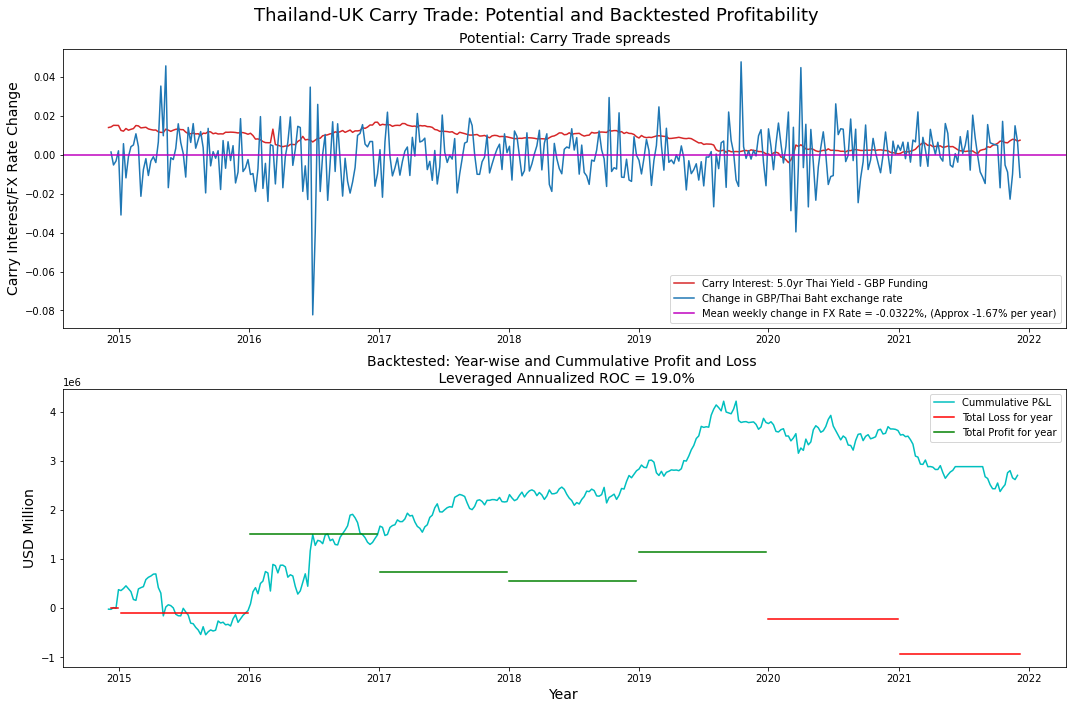

,Mean Annualized Return (NonCompunded),Annualized Volatility,Sharpe Ratio,Skewness,Excess Kurtosis,Biggest Loss,Maximum Gain,% time positive
Thailand-UK Weekly Carry Trade Returns,0.192015,0.429901,0.44665,0.416788,5.241838,-0.231832,0.359847,51.37


In [16]:
carry_trade_potential(TH)

#### Observations: <br>
<b> 1. Interest Differentials: </b> For Thailand carry trade, we observe a much smaller interest rate differential between Thai yield curve and the British Lending rate of OIS + 50 bps. The spread has narrowed over time which could provide the opportunity to profit momentatily but not over sustained time periods. The spreads have even become negative during some time periods. Note that we do not initiate any trades when the UK and Thai yield spreads are not adequate.<br>
<b> 2. Exchange Rates :</b>  During the period of our study, <b> Thai Bhat has appreciated against GBP <b> giving an opportunity to profit from the currency movements from carry trades.</b> Again this is contrary to economic expecations and may not hold true over long time horizons.</b> <br>
<b> 3. Yearly Performances : </b> Most of the years gave returns in a small band of USD 1 Million loss to USD 2 Million profits. The returns seem to come more from gains in THB exchange rate rather than from the carry interest rate differentials. <b> The strategy has provided negative returns in the last two years owing to very thin carry spreads and general weekening of THB against GBP.</b> While we did observe higher volatility in currency exchange rates during the onset of Covid-19 crisis, the changes reverted quickly. <br>
<b> 4. Strategy Returns : </b> The strategy, with the use of leverage, provided a modest annualized Return of 19.27%. The returns are not very volatile and show no major skew. However, the strategy is profitable only in 51.3% of the traded periods which may not be an attribute for a feasable trading strategy.

Again as opposed to general expectation of negative skew in carry trade, this strategy does not exhibit very high skewness and kurtosis in returns. We study the distributions of returns next.

#### Distribution of Returns
Now we track the distribution of our return series to better categorize the probability and magnitude of our expected losses.

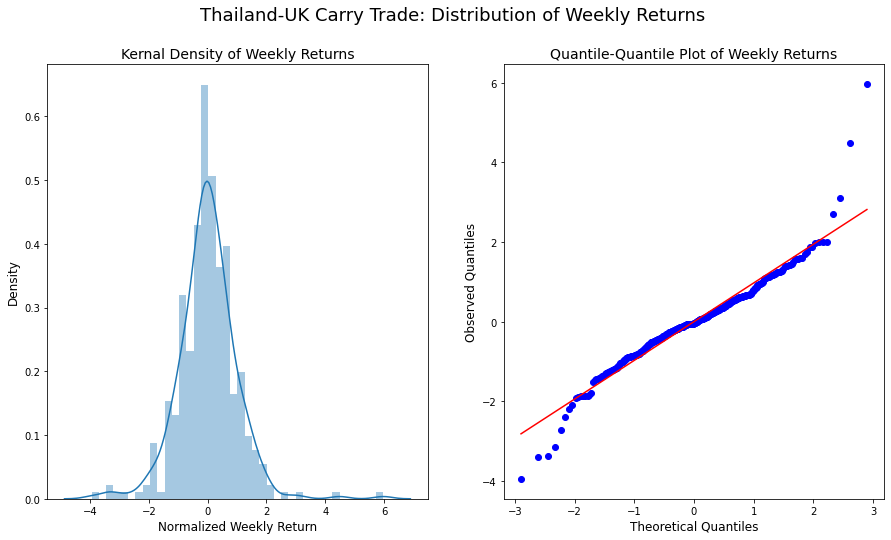

In [17]:
distribution_analysis(TH)

<b> Observations: </b> 

<b> 1. Kernal Density: </b> We observe a fairly symmetric returns distribution in the Kernal density function generated. Most of the density is centred around the normalized mean (about 0.5) with quickly thinning our tails. <br>
<b> 2. Quantile - Quantile plots: </b> The quantiles confer most of the returns on the normally distributed line however we do have larger deviations in the tails. Especailly, there are more large negatively skewed observations than large positively skewed ones.However, some positive deviations are up to six standard deviations normal returns. On the whole the data is prone to muliple outliers in returns. This could make the returns quite volatile, especially during shorter investment horizons.

#### UK to Thailand Carry Trade - Conclusions
- We observed a moderate return low risk backtested return strategy for the carry trade
- We may attribute these returns to strengthening of THB with respect to GBP while having moderate yield from Carry Trade spread.
- <b> As we did not observe any lasting large scale currency or interest rate events during the study period, our backtested strategy may not capture Black Swan events. The strategy is expected to generate moderate returns for extended periods of time which may be wiped out by large loss events. 

### III. Philippines

Philippines was one of the fastest growing Asian economy with robust Foreign Direct Investments growth up to 2018. Late in 2018, the growth hit a 4 year low and the inflation rose sharply from below 2% to 6.6%. 

In 2019, the Central Bank had to cut interest rates and in 2020, the growth again plunged at the onset of Covid-19 crisis. Yet the Philippine Peso did not depricaite as sharply against the US Dollar and the yiled curve remained substantially above the Developed Market debt levels.

#### Carry Trade Potential

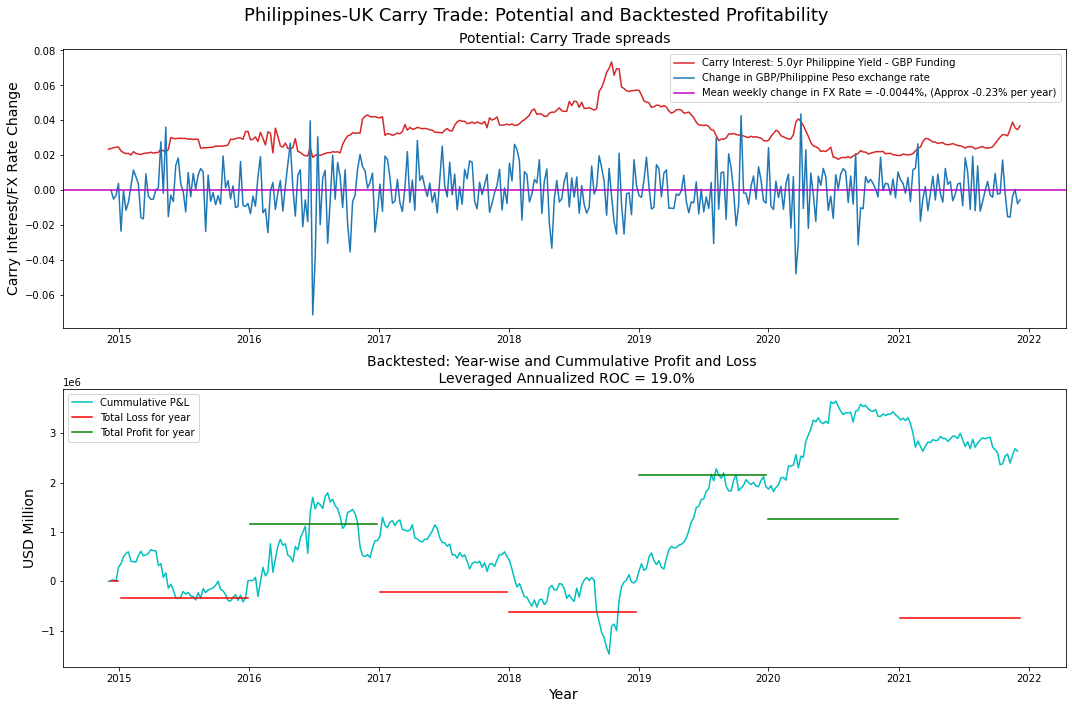

,Mean Annualized Return (NonCompunded),Annualized Volatility,Sharpe Ratio,Skewness,Excess Kurtosis,Biggest Loss,Maximum Gain,% time positive
Philippines-UK Weekly Carry Trade Returns,0.18736,0.572073,0.327511,0.329003,4.052249,-0.317484,0.419657,52.73


In [18]:
carry_trade_potential(PHL)

#### Observations: <br>
<b> 1. Interest Differentials: </b> For Philippines carry trade, we observe a lot of volatility in the Interest Rate differentials that varies between 2% and 7% in the period of study. Unlike South African and Thai yields, this could be a reason for volatility in our returns. <br>
<b> 2. Exchange Rates :</b>  During the period of our study, <b> Philippine Peso has appreciated against GBP <b> giving an opportunity to profit from the currency movements from carry trades.</b> Again this is contrary to economic expecations and may not hold true over long time horizons.</b> <br>
<b> 3. Yearly Performances : </b> The carry trade strategy gave a weak performance up to 2019. <b> In 2019 and 2020, the strategy gave very good results as we could have consistently locked in higher interest rates on our investments in a falling interest rate regime. </b>
<br>
<b> 4. Strategy Returns : </b> The strategy, with the use of leverage, provided a modest annualized Return of 19%. The returns are not very volatile and show a positive skew. The strategy is profitable only about 53% of the traded periods which may not be an attribute for a feasable trading strategy.

Again as opposed to general expectation of negative skew in carry trade, this strategy does not exhibit very high skewness and kurtosis in returns. We study the distributions of returns next.

#### Distribution of Returns
Now we track the distribution of our return series to better categorize the probability and magnitude of our expected losses.

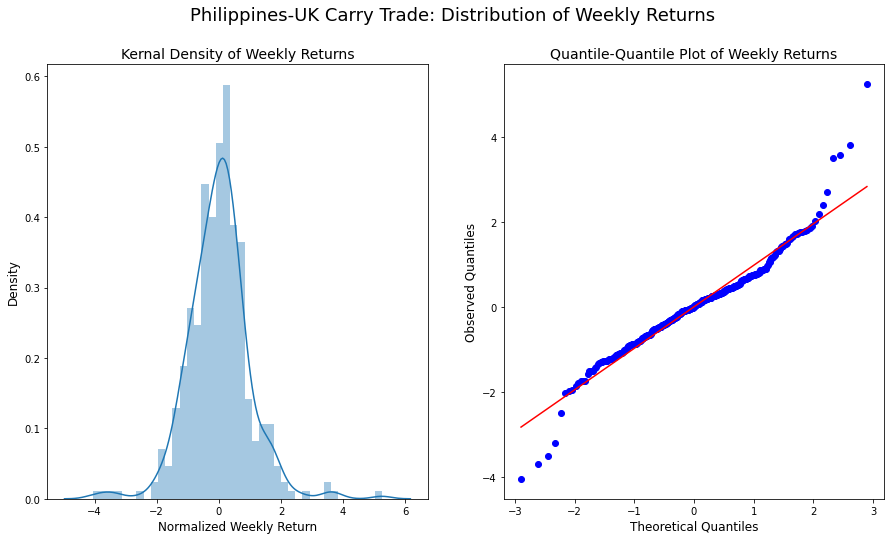

In [19]:
distribution_analysis(PHL)

<b> Observations: </b> 

<b> 1. Kernal Density: </b> We again observe a fairly symmetric returns distribution in the Kernal density function generated with most of the density centred around the normalized mean (about 0.5) with quickly thinning out tails. The positive returns give a fatter right tail than the negative returns tail. <br>
<b> 2. Quantile - Quantile plots: </b> The quantiles confer most of the returns on the normally distributed line however we do have larger deviations in the tails. Especailly, there are more large positively skewed observations than large negatively skewed ones. The positive deviations are up to six standard deviations above the normal returns. On the whole the data is prone to muliple outliers in returns. This could make the returns quite volatile, especially during shorter investment horizons.

#### UK to Philippines Carry Trade - Conclusions
- We observed a moderate return low risk backtested return strategy for the carry trade
- We may attribute these returns to strengthening of Peso with respect to GBP while having moderate yield from Carry Trade spread.
- <b> The strategy gave moderately high returns even with multiple changes to the interest rates. However the period witnessed strengthening of Peso with respect to GBP. The strategy would underperform substantially if GBP were to strengthen against the Peso.

### IV. Pakistan
Pakistan offers one of the highest interest rates while maintaining a stable currency. The Pakistan central bank cut interest rates in 2015 but the carry potential still remained high over the next 3 years. The rates started rising again in late 2018. The yield curves inverted in 2019 and the 5 year rates remained high since then.

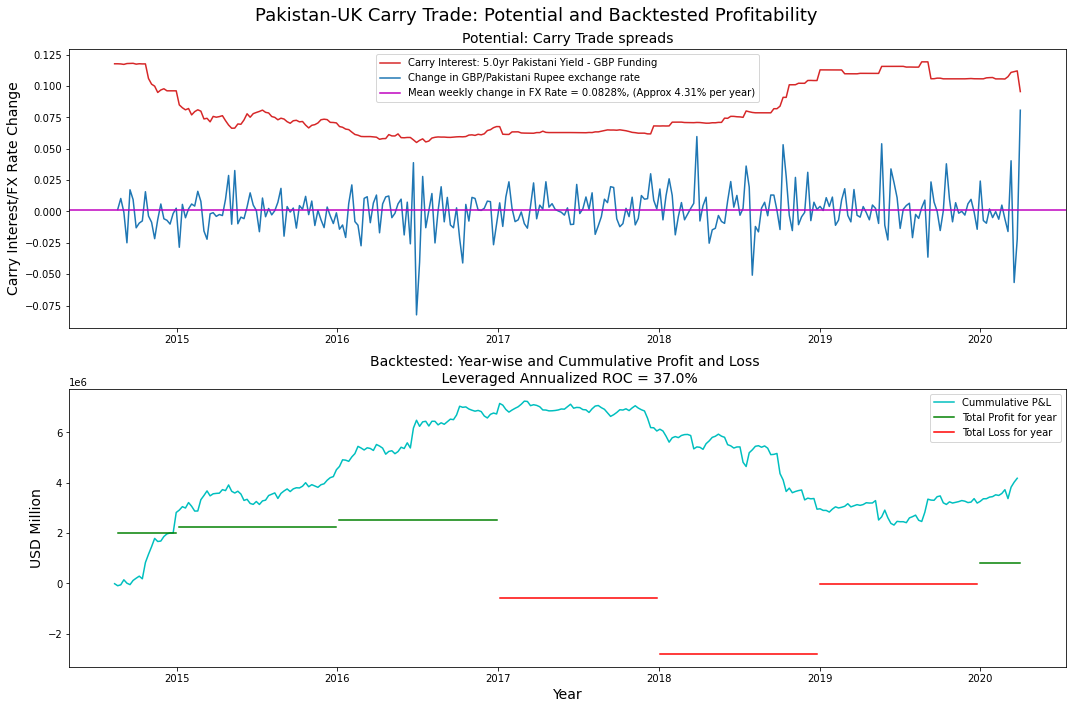

,Mean Annualized Return (NonCompunded),Annualized Volatility,Sharpe Ratio,Skewness,Excess Kurtosis,Biggest Loss,Maximum Gain,% time positive
Pakistan-UK Weekly Carry Trade Returns,0.36941,0.661804,0.558186,-0.025843,4.984972,-0.400133,0.408254,55.78


In [20]:
carry_trade_potential(PAK)

#### Observations: <br>
<b> 1. Interest Differentials: </b> For Pakistan carry trade, we observe a steep interest rate differential averaging around 10% above the UK borrowing rate. The domestic interest rates kept falling gradually from 2014 to 2018 before rising back again up to 2020.<br>
<b> 2. Exchange Rates :</b>  Pakistani Rupee remained strong during the first half of our strategy backtesting up to 2017 and then gave away the strength it had built. On average, Pakisatani Rupee decline around 4.3% each year against GBP which is much lower than the interest rate differentials between the respective currencies. <br>
<b> 3. Yearly Performances : </b> The carry trade strategy gave a strong performance in the first three years riding on locking higher yields in the weekly investment strategies during a falling interest rate regime. THe Pakisatni Rupee also remained strong during the period which defantely helped the strategy. In 2019 and 2020, the strategy started making losses with rise in interest rates as each subsequent investment would get locked in at a lower rate. <br>
<b> 4. Strategy Returns : </b> The strategy generates high returns at elevated volatility. With a leveraged return of 37% during the investment horizon, the strategy gives an impressive return primarily from a strong interest rate differntial.

Again as opposed to general expectation of negative skew in carry trade, this strategy does not exhibit very high skewness and kurtosis in returns. We study the distributions of returns next.

#### Distribution of Returns
Now we track the distribution of our return series to better categorize the probability and magnitude of our expected losses.

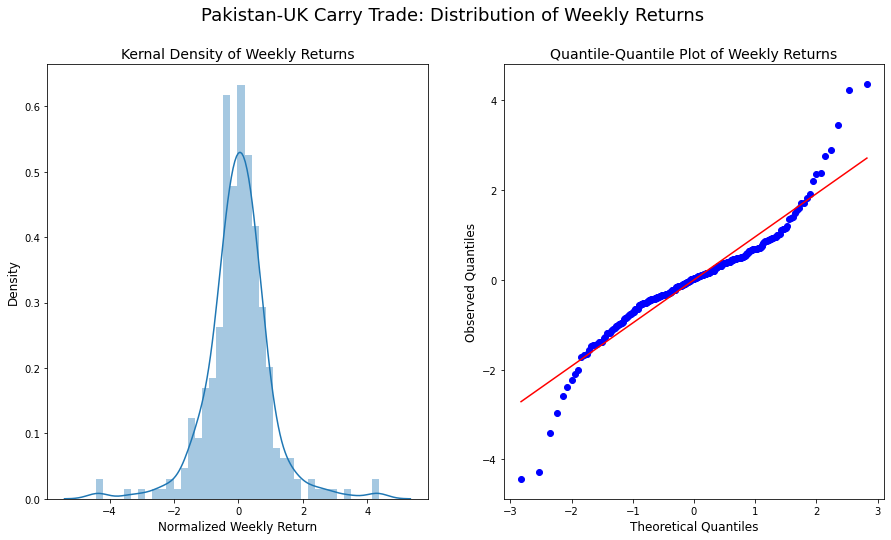

In [21]:
distribution_analysis(PAK)

<b> Observations: </b> 

<b> 1. Kernal Density: </b> We observe a fairly symmetric returns distribution in the Kernal density function generated. Most of the density is centred around the normalized mean (about 0.5) with quickly thinning our tails. <br>
<b> 2. Quantile - Quantile plots: </b> The quantiles confer most of the returns on the normally distributed line however we do have larger deviations in the tails on both the ends. This could make the returns quite volatile, especially during shorter investment horizons.

#### UK to Pakistan Carry Trade - Conclusions
- We observed a high profitability in carry trading owing primarily to large interest rate differentials between UK borrowing rate and Pakistan lending rate.
- Even with an average deprication of Pakistani Rupee by about 4% per year, we witnessed the carry trade differential to provide substantial returns.
- <b> The strategy gave healthy returns even with multiple changes to the interest rates and broad deprication of Pakistani Rupee. Thus this strategy may be reliably replicated.

## 5. Correlations of the Carry Trading Returns

Emerging market yields and FX rates are highly correlated. Thus is is natural to expect a high correlation in the returns generated from carry trade strategies. Also, considering the leveraged nature of these strategies, it may be prudent to understand the correlation relationships of these strategies to the fear guage, VIX index and to other debt return benchmarks. Here we use the VIX index, the US AAA Bond index and Emerging Market Debt indices to compare the strategy return correlations.

In [22]:
vix = nasdaqdatalink.get_table('SCF/PRICES', quandl_code='CBOE_VX1_EB',date = {'gte': '2010-06-30', 'lte': '2022-01-31'},\
                        qopts = { 'columns':['date','settle']})[::-1].set_index('date').resample('W-WED').ffill()

#https://data.nasdaq.com/data/ML/AAATRI-us-aaa-corporate-bond-total-return-index
US_AAA_Bond = nasdaqdatalink.get("ML/AAATRI")

#https://data.nasdaq.com/data/ML/EMCTRI-emerging-markets-corporate-bond-total-return-index
EmergingMarketDebt = nasdaqdatalink.get("ML/EMCTRI")


In [23]:
strategyReturns = pd.DataFrame(index = GB['OIS'].index)

strategyReturns['SouthAfricaCarryReturns'] = SA['Strategy'].set_index('ExitDate').returns
strategyReturns['ThailandCarryReturns'] = TH['Strategy'].set_index('ExitDate').returns
strategyReturns['PhilippinesCarryReturns'] = PHL['Strategy'].set_index('ExitDate').returns
strategyReturns['PakistanCarryReturns'] = PAK['Strategy'].set_index('ExitDate').returns

strategyReturns['SouthAfricaZCBReturns'] = SA['zcb'][5]/SA['zcb'][5].shift() - 1
strategyReturns['ThailandZCBReturns'] = TH['zcb'][5]/TH['zcb'][5].shift() - 1
strategyReturns['PhilippinesZCBReturns'] = PHL['zcb'][5]/PHL['zcb'][5].shift() - 1
strategyReturns['PakistanZCBReturns'] = PAK['zcb'][5]/PAK['zcb'][5].shift() - 1
 
strategyReturns['US_AAA_Bond_Returns'] = US_AAA_Bond/US_AAA_Bond.shift() - 1
strategyReturns['EmergingMarketDebtReturns'] = EmergingMarketDebt/EmergingMarketDebt.shift() - 1
strategyReturns['VIX Index'] = vix/vix.shift() - 1

strategyReturns = strategyReturns.dropna()

### I. Correlation of FX Carry Strategy Returns among different Carry Trade countries

First we analyze the correlation relationships among each of the four carry trade strategy. 

<AxesSubplot:>

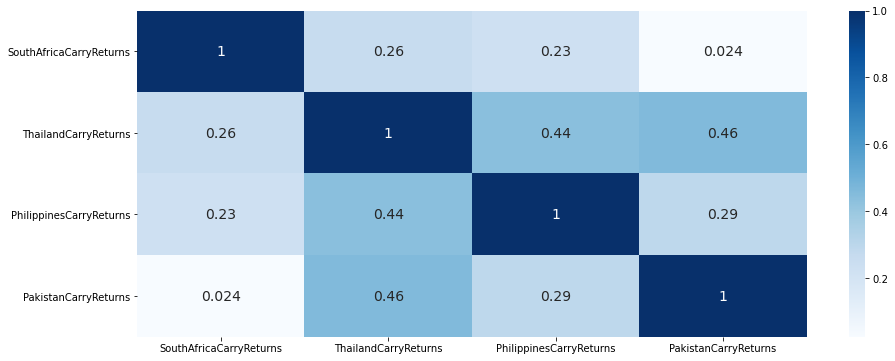

In [24]:
sns.heatmap(strategyReturns.corr().iloc[0:4,0:4],annot=True,cmap="Blues",annot_kws={"size":14})

<b> Observations :</b>
1. The <b> returns from the Asian carry trade strategies (Thailand, Philippines and Pakistan) are highly correlated </b> with coefficients between 0.3 and 0.46. 
2. South Africa Carry Trade returns are also somewhat correlated with Thai and Philippines carry returns.

We shall study the evolution of these correlations over time in a section IV below.

### II. Correlation of FX Carry Strategy returns with underlying Zero Coupon Rates
Next, we try analyzing the correlation relationship of our trading strategy to their underlying yield curves.

<AxesSubplot:>

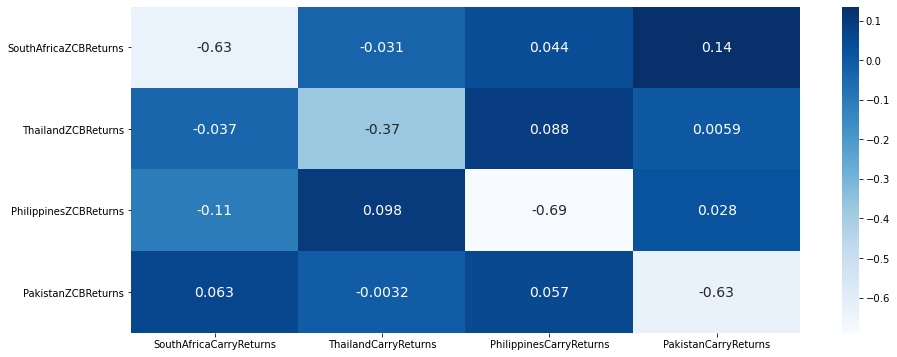

In [25]:
sns.heatmap(strategyReturns.corr().iloc[4:8,0:4],annot=True,cmap="Blues",annot_kws={"size":14})

<b> Observations </b> 

We observe very <b> high negative correlations along the principal diagonal </b> indicating a strong relationship between returns and changes in yield curve. Note that the negative sign indicates that an increase in yield curve rate typically results in a loss as we are locked in at a lower yield when the yield curve moves up resulting in a loss.

<b> All other cross correlations are quite small indicating it may not be easy to time trading returns for a strategy from changes in the yield curves of other currencies, or such changes get quickly reversed out leading to low correlation.</b>

### III. Correlations with Debt Indices and VIX
As a fixed income strategy, we now try analyzing the performance with respect to US AAA Bond benchmark returns, Emerging market debt returns and returns with respect to the volatility index VIX.

<AxesSubplot:>

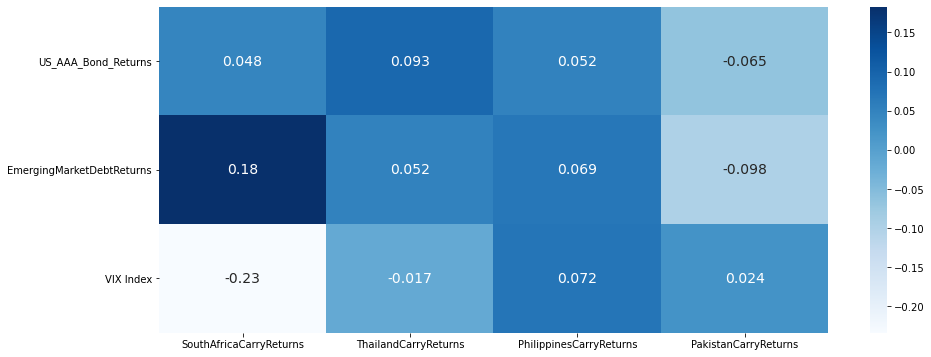

In [26]:
sns.heatmap(strategyReturns.corr().iloc[8:,0:4],annot=True,cmap="Blues",annot_kws={"size":14})

<b> Observations: </b> We have very low correaltions with benchmarks and thus such a carry trade strategy may provide good diversification benefits with respect to other fixed income strategies. Also, in general, the strategies have low correlation to VIX and thus even during high fear and flight to safety, out strategies are expected to provide decent returns. This is an important consideration in a multi-country strategy.

### IV. Correlations over the years: 2015 to 2020
Finally, we observe the correlations of our strategies amongst each other and with the VIX index over time

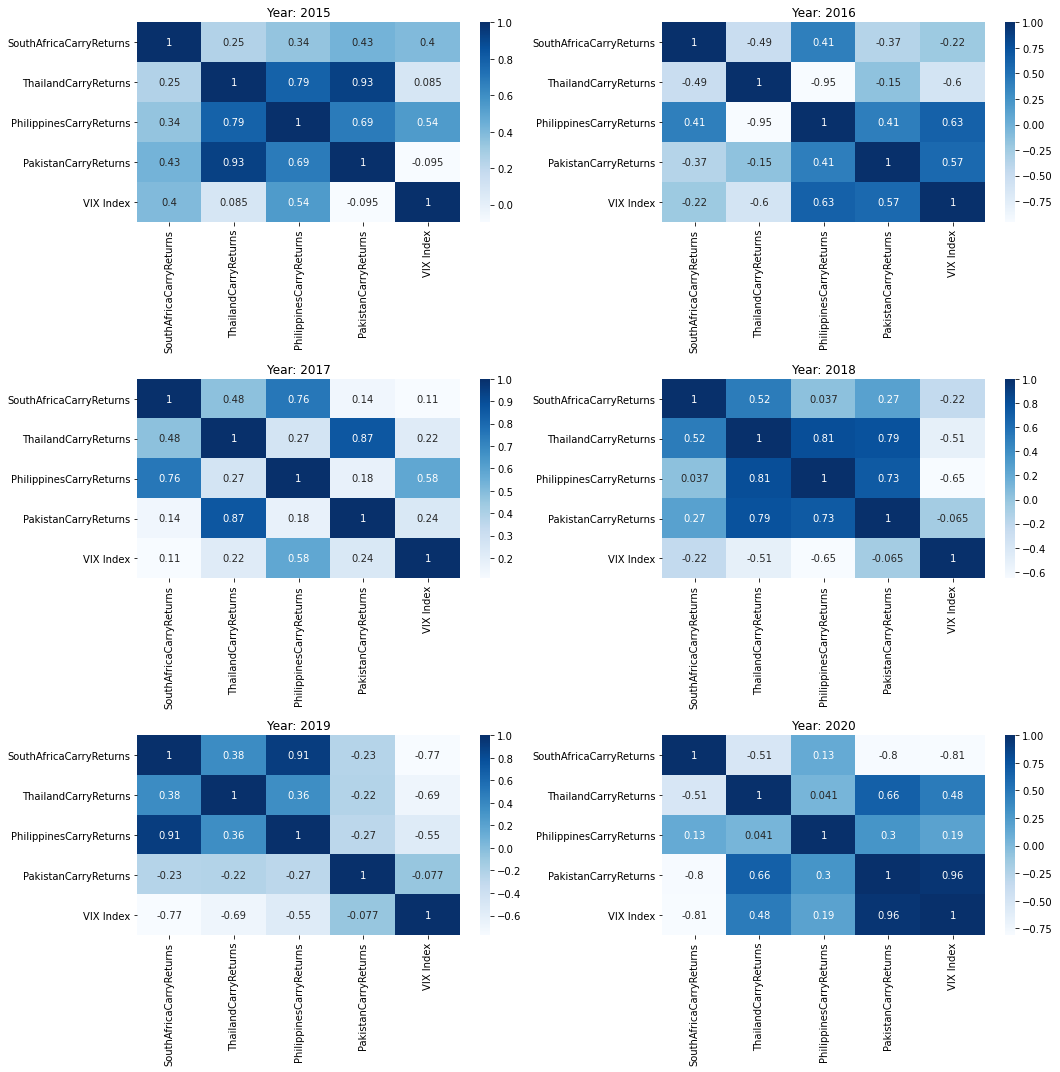

In [27]:
fig, ax = plt.subplots(3, 2, figsize=(15, 15))
for i,y in enumerate(range(2015,2021)):
    idx = (i//2,i%2)
    sns.heatmap(strategyReturns[str(y)].iloc[[0,1,2,3,10],[0,1,2,3,10]].corr(),ax = ax[idx],annot=True,cmap="Blues")
    ax[idx].set(title = "Year: "+str(y))
    fig.tight_layout()

<b> Observations: </b>
1. We observe very high correlations among the carry trade currencies in all the years up to 2019. In 2020, there was a steep rise in South African interest rates and the correlation with other currencies declined sharply. We may consider this to be a one-off event and consider the correlations among the Carry Trade currencies to be between 0.2 and 0.5 in general.
2. In 2020, VIX returns are highly correlated to carry trade returns indicating that during times of extreme fear, the returns from carry trade would be correlated to other assets. This limits the use of these strategies as a diversifier.

## Conclusions

- As outlined in the objectives, we backtested our carry trade strategy over a period of around seven years in four emerging market debt
- We observed profitability in each of the emerging market yield curve carry trade strategy. 
- The returns did not show disproportionate negative skews indicating that such strategies could be implemented practically.
- The strategies worked well especially because the respective emerging market currencies did not depriciate much and thus allowed to benefit from the interest rate differential.
- We could thus reject the application of Interest Rate Pairity over the observed data period.
- Broadly, we can attribute the returns as follows:
-- South Africa and Pakistan carry trades generated healthy returns primarily because of large interest rate differentials. We may prefer these destinations for carry trade because of stable currency and higher profitability potential.
-- Thailand and Philippines carry trades generated  returns primarily because of strength in the underlying currency with respect to GBP. We may rank such strategies lower as the profitability potential and realization is lower and the returns are highly dependent on the gains from currency movements.

<b> Areas of improvements: </b>
- The period of study had stable currencies in emerging markets. Furhter, the borrowing currency GBP itself witnessed declines with respect to USD and thus the strategies showed higher returns especially during Brexit in June 2016. We may consider scenarios of steep declines in currency rates to better backtest the returns and understnad the tail risks.
- Increasing the study's time frame, expanding the analysis to other emerging market currencies, incorporating borrowing from other Developed markets such as US, Eurozone, Japan could be included to study the dynamics of carry trade from multiple perspectives.